# Pressor Distributions
- Ruoyi Jiang
- July 19, 2019
- Evaluation of the different pressor combinations used in MIMIC

In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(fasttime)
library(epitools)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Filtering criteria:
- Groupby continuous courses (<24 hour intervals between pressors not considered separate)
- Exclude those on pressors within 1 hr of hospital
- First pressor course

In [2]:
pressors_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/pressors.csv')

In [3]:
dim(pressors_df)

[1] 227645     11

In [328]:
pressors_df %>%
    filter(pressor == "central_line_durations") %>% head()

X,level_0,level_1,duration_hours,endtime,icustay_id,num,pressor,starttime,vasonum,ventnum
<int>,<fct>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
30584,central_line_durations,0,70.91667,2181-11-28 20:59:00,200001,NA,central_line_durations,2181-11-25 22:04:00,NA,NA
30585,central_line_durations,1,134.00000,2199-08-08 15:00:00,200003,NA,central_line_durations,2199-08-03 01:00:00,NA,NA
30586,central_line_durations,2,37.75000,2189-12-02 08:00:00,200009,NA,central_line_durations,2189-11-30 18:15:00,NA,NA
30587,central_line_durations,3,19.68333,2132-08-05 20:36:00,200010,NA,central_line_durations,2132-08-05 00:55:00,NA,NA
30588,central_line_durations,4,23.76667,2114-12-27 22:46:00,200021,NA,central_line_durations,2114-12-26 23:00:00,NA,NA
30589,central_line_durations,5,9.30000,2127-03-04 01:18:00,200024,NA,central_line_durations,2127-03-03 16:00:00,NA,NA


In [83]:
pressors_df %>%
    filter(pressor == "ventdurations") %>% head()

X,level_0,level_1,duration_hours,endtime,icustay_id,num,pressor,starttime,vasonum,ventnum
<int>,<fct>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
189130,ventdurations,0,91.00000,2199-08-07 13:00:00,200003,NA,ventdurations,2199-08-03 18:00:00,NA,1
189131,ventdurations,1,14.83333,2159-09-04 03:50:00,200006,NA,ventdurations,2159-09-03 13:00:00,NA,1
189132,ventdurations,2,15.83333,2189-12-01 10:00:00,200009,NA,ventdurations,2189-11-30 18:10:00,NA,1
189133,ventdurations,3,3.00000,2188-08-06 04:00:00,200011,NA,ventdurations,2188-08-06 01:00:00,NA,1
189134,ventdurations,4,18.75000,2105-02-17 18:00:00,200014,NA,ventdurations,2105-02-16 23:15:00,NA,1
189135,ventdurations,5,83.00000,2138-03-21 09:00:00,200017,NA,ventdurations,2138-03-17 22:00:00,NA,1


In [329]:
pressors_df %>%
    filter(pressor == 'norepinephrinedurations')  %>%
    mutate(SHORT = duration_hours < 24) %>%
    group_by(SHORT) %>% 
    summarize(COUNT = n())

SHORT,COUNT
<lgl>,<int>
FALSE,3407
TRUE,19781


### Available pressor (and other infusions) choices

In [227]:
unique(pressors_df$pressor)

[1] adenosinedurations      arterial_line_durations central_line_durations 
 [4] crrtdurations           dobutaminedurations     dopaminedurations      
 [7] epinephrinedurations    isupreldurations        milrinonedurations     
[10] norepinephrinedurations phenylephrinedurations  vasopressindurations   
[13] vasopressordurations    ventdurations          
14 Levels: adenosinedurations ... ventdurations

# Histograms of pressor durations for norepi

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 496 rows containing non-finite values (stat_bin).”Warning message:
“Removed 496 rows containing non-finite values (stat_density).”

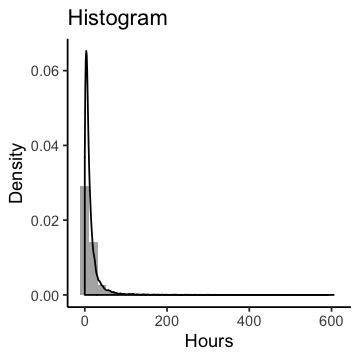

In [15]:
options(repr.plot.width=3, repr.plot.height=3)
pressors_df %>%
    filter('norepinephrinedurations' == pressor) %>%
    mutate(DIFF = 
              difftime(fastPOSIXct(endtime), 
               fastPOSIXct(starttime), units="hours")) %>%
    ggplot(aes(x=DIFF)) +
        geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(alpha=0.6)+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="Histogram",x="Hours", y = "Density")+
        theme_classic()

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


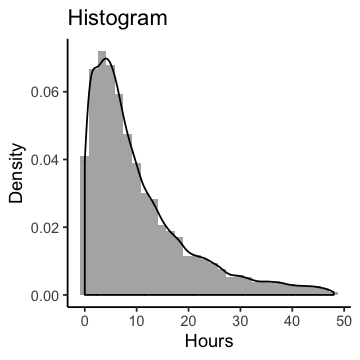

In [16]:
options(repr.plot.width=3, repr.plot.height=3)
pressors_df %>%
    filter('norepinephrinedurations' == pressor) %>%
    mutate(DIFF = 
              difftime(fastPOSIXct(endtime), 
               fastPOSIXct(starttime), units="hours")) %>%
    filter(DIFF < 48) %>%
    ggplot(aes(x=DIFF)) +
        geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(alpha=0.6)+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="Histogram",x="Hours", y = "Density")+
        theme_classic()

### Join with icustay metadata

In [138]:
lengthstay_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/length_stay.csv') %>%
    rename(icustarttime = START, icuendtime = END)

In [139]:
lengthstay_df %>% head()

X,icustay_id,icustarttime,icuendtime,DIFF
<int>,<int>,<fct>,<fct>,<dbl>
1,200001,2181-11-25 19:06:00,2181-11-28 20:00:00,72.90000
2,200003,2199-08-02 19:15:00,2199-08-08 15:00:00,139.75000
3,200006,2159-09-03 12:30:00,2159-09-04 17:00:00,28.50000
4,200007,2109-02-17 09:00:00,2109-02-18 09:15:00,24.25000
5,200009,2189-11-30 11:43:00,2189-12-02 13:00:00,49.28333
6,200010,2132-08-05 00:39:00,2132-08-05 21:17:00,20.63333


In [140]:
# filter by pressor and left join with lengthstay_df
input_df <- pressors_df %>%
    filter('norepinephrinedurations' == pressor) %>%
    left_join(lengthstay_df, by = "icustay_id") %>%
    mutate(starttime = fastPOSIXct(starttime), endtime = fastPOSIXct(endtime), 
           icustarttime = fastPOSIXct(icustarttime), icuendtime = fastPOSIXct(icuendtime))

# Analyze Filters (7/31/19)

#### Collapse pressor courses based on length of intervening time (<24 hrs)
- Any two courses with less than intervening 24 hours will be collapsed into a single course within an icustay

In [141]:
max_intervening_hrs <- 24

# find the intervening time between courses (endtime of next course - endtime of course - duration of course)
# then determine if that length of time is >24 or <24 and mark it with a 0 if true, else a 1
# use a cumsum to create a new id separating courses that are separated by more than >24
input_df <- input_df %>%
    group_by(icustay_id) %>%
    mutate(intervening_hours = difftime(endtime, lag(endtime), units="hours") - duration_hours) %>%
    rowwise() %>%
    mutate(increasing = if(intervening_hours < max_intervening_hrs | is.na(intervening_hours)){0}else(1)) %>%
    ungroup() %>%
    group_by(icustay_id) %>%
    mutate(continuous_course = cumsum(increasing)) %>% select(-intervening_hours, -increasing)

In [142]:
# input_df %>%
#     filter(icustay_id %in% c(299386, 299415, 200206)) %>%
#     mutate(intervening_hours = difftime(endtime, lag(endtime), units="hours") - duration_hours) %>%
#     rowwise() %>%
#     mutate(increasing = if(intervening_hours < max_intervening_hrs | is.na(intervening_hours)){0}else(1)) %>%
#     ungroup() %>%
#     group_by(icustay_id) %>%
#     mutate(continuous_course = cumsum(increasing))

- the combination of **continuous course** and **icustay_id** (e.g. 200024, 0 for first row) now defines each pressor course

- assign boolean assessments after <24 hour intervals between pressors are removed
    1. more or less than 24 hours of pressor duration?
    2. is this the first pressor course?
    3. are pressors administered <1 hr of the icustay?

In [143]:
# 1. more or less than 24 hours?
input_df <- input_df %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(MORETHAN24HOURS = sum(duration_hours) > 24)

In [144]:
# 2. first pressor course? (groupby icustay, filter min starttime == starttime)
input_df <- input_df %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(coursestarttime = min(starttime)) %>%
    group_by(icustay_id) %>%
    mutate(FIRSTCOURSE = min(coursestarttime) == coursestarttime)

In [145]:
# 3. pressors within 1 hr of icustay_id? (groupby icustay, filter max starttime - unique icustarttime > 1)
input_df <- input_df %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(coursestarttime = min(starttime)) %>%
    group_by(icustay_id) %>%
    mutate(LESS1HOUR = difftime(min(coursestarttime), 
                         min(icustarttime)) < 1)

In [146]:
# grouped by icustay_id + continuous_course + separate_course
input_df %>%
    group_by(LESS1HOUR, FIRSTCOURSE, MORETHAN24HOURS) %>%
    summarize(COUNT = n())

LESS1HOUR,FIRSTCOURSE,MORETHAN24HOURS,COUNT
<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,876
FALSE,FALSE,TRUE,2077
FALSE,TRUE,FALSE,5357
FALSE,TRUE,TRUE,12605
TRUE,FALSE,FALSE,35
TRUE,FALSE,TRUE,69
TRUE,TRUE,FALSE,356
TRUE,TRUE,TRUE,455
NA,FALSE,FALSE,65


In [459]:
# With filters grouped by icustay_id + continuous_course
input_df %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(LESS1HOUR, FIRSTCOURSE, MORETHAN24HOURS) %>%
    summarize(COUNT = length(unique(course_id)))

LESS1HOUR,FIRSTCOURSE,MORETHAN24HOURS,COUNT
<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,583
FALSE,FALSE,TRUE,489
FALSE,TRUE,FALSE,3700
FALSE,TRUE,TRUE,2918
TRUE,FALSE,FALSE,22
TRUE,FALSE,TRUE,12
TRUE,TRUE,FALSE,268
TRUE,TRUE,TRUE,135
NA,FALSE,FALSE,44


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 2 rows containing missing values (geom_bar).”

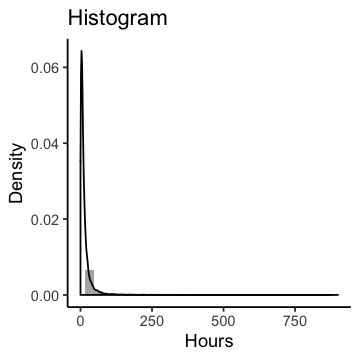

In [285]:
options(repr.plot.width=3, repr.plot.height=3)
input_df %>%
    ggplot(aes(x=duration_hours)) +
        geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(alpha=0.6)+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="Histogram",x="Hours", y = "Density")+
        theme_classic() + xlim(0, 900)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”Warning message:
“Removed 1 rows containing non-finite values (stat_density).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”

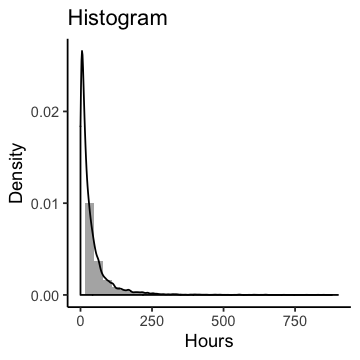

In [286]:
options(repr.plot.width=3, repr.plot.height=3)
input_df %>%
    group_by(icustay_id, continuous_course) %>%
    summarize(duration_hours = sum(duration_hours)) %>%
    ggplot(aes(x=duration_hours)) +
        geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(alpha=0.6)+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="Histogram",x="Hours", y = "Density")+
        theme_classic() + xlim(0, 900)

In [132]:
#write.csv(input_df, '~/Projects/Haimovich_Pressors/collection/out/pressors_filtered.csv')

### Mortality filter
- Remove patients who stopped using pressors because death (merge with pressors_df by icustay_id, filter if pressor course end time == or is close to deathtime)

In [147]:
icustays_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/icustays.csv')

In [148]:
admissions_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/admissions.csv')

In [149]:
patients_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/patients.csv')

In [332]:
intub_df <- pressors_df %>%
    filter(pressor == "ventdurations") 

cvc_df <- pressors_df %>%
    filter(pressor == "central_line_durations") 

In [333]:
nonvitals_predictor_df <- icustays_df %>%
    select(hadm_id, icustay_id, first_careunit, last_careunit) %>%
    left_join(admissions_df, by = 'hadm_id') %>%
    left_join(patients_df, by = 'subject_id') %>%
    mutate(intub = icustay_id %in% intub_df$icustay_id, cvc = icustay_id %in% cvc_df$icustay_id) %>%
    mutate(deathtime = fastPOSIXct(deathtime), admittime = fastPOSIXct(admittime), dob = fastPOSIXct(dob)) %>%
    mutate(age = difftime(admittime, dob, units="weeks")/52.25, age_cohort = as.numeric(round(age, digits = -1)))

In [152]:
# info about what each service covers which diagnoses
nonvitals_predictor_df %>% 
    group_by(diagnosis, first_careunit) %>% 
    summarize(COUNT = n()) %>% 
    arrange(-COUNT) %>% head(10)

diagnosis,first_careunit,COUNT
<fct>,<fct>,<int>
NEWBORN,NICU,8455
PNEUMONIA,MICU,2449
SEPSIS,MICU,1729
CORONARY ARTERY DISEASE,CSRU,1406
CONGESTIVE HEART FAILURE,CCU,863
GASTROINTESTINAL BLEED,MICU,817
ALTERED MENTAL STATUS,MICU,810
CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT /SDA,CSRU,768
INTRACRANIAL HEMORRHAGE,SICU,688


In [18]:
#NA means the stay did not end in death
#ICUSTAYS where patient was discharged after death? (TRUE)
nonvitals_predictor_df  %>%
    mutate(MORTALITYERROR = difftime(deathtime, dischtime, units = "mins") < 0) %>%
    group_by(MORTALITYERROR) %>%
    summarize(COUNT = n())

MORTALITYERROR,COUNT
<lgl>,<int>
FALSE,5330
TRUE,1132
NA,55070


In [19]:
#NA means the stay did not end in death
#ICUSTAYS where patient was admitted after death? (TRUE)
nonvitals_predictor_df  %>%
    mutate(MORTALITYERROR = difftime(deathtime, admittime, units = "mins") < 0) %>%
    group_by(MORTALITYERROR) %>%
    summarize(COUNT = n())

MORTALITYERROR,COUNT
<lgl>,<int>
FALSE,6384
TRUE,78
NA,55070


In [20]:
#Examples
nonvitals_predictor_df  %>%
    filter(difftime(deathtime, admittime, units = "mins") < 0) %>%
    head(5)

hadm_id,icustay_id,first_careunit,last_careunit,X.x,row_id.x,subject_id,admittime,dischtime,deathtime,⋯,X.y,row_id.y,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,age,age_cohort
<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<dttm>,<fct>,<dttm>,⋯,<int>,<int>,<fct>,<dttm>,<fct>,<fct>,<fct>,<int>,<drtn>,<dbl>
102631,246694,CSRU,CSRU,456,237,181,2153-10-12 05:49:00,2153-10-12 06:29:00,2153-10-12 02:29:00,⋯,392,171,M,2088-07-23 20:00:00,2153-10-12,2153-10-12,2153-10-12,1,65.12757082 weeks,70
138015,298263,NICU,NICU,1911,1640,1334,2137-09-02 10:43:00,2137-09-02 12:00:00,2137-09-02 08:00:00,⋯,885,1268,M,2137-09-01 20:00:00,2137-09-02,2137-09-02,,1,0.00167654 weeks,0
181430,291798,SICU,SICU,1970,1699,1381,2189-01-02 09:25:00,2189-01-02 12:00:00,2189-01-02 07:00:00,⋯,930,1313,F,2107-07-14 20:00:00,2189-01-02,2189-01-02,2189-01-02,1,81.36049404 weeks,80
187482,213831,MICU,MICU,693,644,516,2197-07-31 16:18:00,2197-07-31 01:10:00,2197-07-30 21:10:00,⋯,686,487,F,2126-08-06 20:00:00,2197-07-31,2197-07-31,2197-07-31,1,70.88679654 weeks,70
190088,293048,CCU,CCU,3624,3447,2858,2108-09-25 11:29:00,2108-09-25 12:00:00,2108-09-25 08:00:00,⋯,3354,2703,F,2026-03-12 20:00:00,2108-09-25,2108-09-25,2108-09-25,1,82.42418356 weeks,80


### Setting a mortality filter

In [317]:
# Icustays where patients received pressors after death (TRUE)
input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    mutate(STOPMORTALITY = difftime(deathtime, endtime, units = "mins")) %>% 
    group_by(STOPMORTALITY < 0) %>%
    summarize(COUNT = length(unique(icustay_id)))

STOPMORTALITY < 0,COUNT
<lgl>,<int>
FALSE,2430
TRUE,437
NA,4689


In [436]:
### if I do not ignore for these unusual cases
input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = STOPMORTALITY < 5) %>%
    group_by(STOPMORTALITY) %>%
    summarize(COUNT = n())

STOPMORTALITY,COUNT
<lgl>,<int>
FALSE,8202
TRUE,1768
NA,13218


In [437]:
### if I do ignore these unusual cases
input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = STOPMORTALITY > 0 &  STOPMORTALITY < 5) %>%
    group_by(STOPMORTALITY) %>%
    summarize(COUNT = n())

STOPMORTALITY,COUNT
<lgl>,<int>
FALSE,9867
TRUE,103
NA,13218


In [336]:
# ignore NAs (patient did not die), or patient death did not correspond to end of pressor course
# do not remove unusual cases
input_death_df <- input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = !(!(STOPMORTALITY < 5) | is.na(STOPMORTALITY)))

In [337]:
input_death_df %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(LESS1HOUR, FIRSTCOURSE, STOPMORTALITY, MORETHAN24HOURS) %>%
    summarize(COUNT = length(unique(course_id)))

LESS1HOUR,FIRSTCOURSE,STOPMORTALITY,MORETHAN24HOURS,COUNT
<lgl>,<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,FALSE,545
FALSE,FALSE,FALSE,TRUE,448
FALSE,FALSE,TRUE,FALSE,38
FALSE,FALSE,TRUE,TRUE,41
FALSE,TRUE,FALSE,FALSE,3448
FALSE,TRUE,FALSE,TRUE,2743
FALSE,TRUE,TRUE,FALSE,252
FALSE,TRUE,TRUE,TRUE,175
TRUE,FALSE,FALSE,FALSE,21


In [303]:
# ignore NAs (patient did not die), or patient death did not correspond to end of pressor course
# remove unusual cases
input_death_df <- input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = !(!(STOPMORTALITY > 0 &  STOPMORTALITY < 5) | is.na(STOPMORTALITY)))

### Exclude NICU (all NICU was already excluded by pressor usage)

In [320]:
input_death_df %>%
    mutate(NICUSTAY = first_careunit == "NICU") %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(LESS1HOUR, FIRSTCOURSE, STOPMORTALITY, MORETHAN24HOURS, NICUSTAY) %>%
    summarize(COUNT = length(unique(course_id)))

LESS1HOUR,FIRSTCOURSE,STOPMORTALITY,MORETHAN24HOURS,NICUSTAY,COUNT
<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,FALSE,FALSE,545
FALSE,FALSE,FALSE,TRUE,FALSE,448
FALSE,FALSE,TRUE,FALSE,FALSE,38
FALSE,FALSE,TRUE,TRUE,FALSE,41
FALSE,TRUE,FALSE,FALSE,FALSE,3448
FALSE,TRUE,FALSE,TRUE,FALSE,2743
FALSE,TRUE,TRUE,FALSE,FALSE,252
FALSE,TRUE,TRUE,TRUE,FALSE,175
TRUE,FALSE,FALSE,FALSE,FALSE,21


### Use filters

In [338]:
output_df <- input_death_df %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(course_id) %>%
    mutate(starttime = min(starttime), endtime = max(endtime)) %>%
    filter(!LESS1HOUR, FIRSTCOURSE, !STOPMORTALITY) 

# RR Tables

In [58]:
races <- c("ASIAN", "BLACK", "HISPANIC", "WHITE", "OTHER")

simplifyRace <- function(ethnicity){
    if(grepl("ASIAN", ethnicity)){return("ASIAN")}
    else if(grepl("BLACK", ethnicity)){return("BLACK")}
    else if(grepl("HISPANIC", ethnicity)){return("HISPANIC")}
    else if(grepl("WHITE", ethnicity)){return("WHITE")}
    else{return("OTHER")}
}

In [295]:
sepsis_regex <- c('SEPSIS', 'SEPTIC', 'CHOLANGITIS', 'UROSEPSIS')

infection_regex <- c('PNEUMONIA', 'INFECTION',  
  'CELULLITIS', 'FASCITIS', 'INFECTED', 'BACTER', 'PNEMONIA', 'ABSCESS', 'NEPHRITIS')

cardiac_regex <- c('HEART', 'CORONARY', 'VENTRICULAR')

simplifyDiagnosis <- function(diagnosis){
    if(any(sapply(sepsis_regex, function(x) grepl(x, diagnosis)))){return("SEPSIS")}
    else if(any(sapply(infection_regex, function(x) grepl(x, diagnosis)))){return("INFECTION")}
    else if(any(sapply(cardiac_regex, function(x) grepl(x, diagnosis)))){return("CARDIAC")}
    else{return("OTHER DIAGNOSIS")}
}

Second: Let’s pause the sophisticated (and more interesting) analysis to build out our manuscript table 1 and supp tables 1-3. Details in the doc, but I imagine this as a classic table 1 where you show group characteristics. Hopefully R has a straight-forward way of dumping these out. (https://cran.r-project.org/web/packages/tableone/vignettes/introduction.html)

 

T1: composite of levophed, dopamine, phenylephrine X [all patients; single pressor < 6 hours; single pressor < 24 hours; single pressor > 24 hours or multiple pressors at any point]

S1-S3: blow-out of levophed, dopamine, phenylephrine X [all patients; single pressor < 6 hours; single pressor < 24 hours; single pressor > 24 hours or multiple pressors at any point]

P-values to compare < 24 vs > 24 or multiple pressors

+/- Relative risks for categorical variables?

 

In [ ]:
#TODO: incorporate other pressors
#Forest plots for RR

In [342]:
output_df %>% 
    rowwise() %>%
    mutate(simple_race = simplifyRace(ethnicity)) %>%
    mutate(simple_diagnosis = simplifyDiagnosis(diagnosis)) %>%
#     mutate(STATUS = 
#             if(duration_hours <= 6){"LESS6HOURS"}
#             else if(duration_hours <= 24 & duration_hours > 6){"LESS24HOURS"}
#             else if(duration_hours > 24){"MORE24HOURS"}) %>%
#     group_by(course_id, MORETHAN24HOURS) %>%
#     summarize(age = mean(age), 
#               gender = unique(gender)[1],
#               simple_race =  unique(simple_race)[1],
#               simple_diagnosis =  unique(simple_diagnosis)[1],
#               first_careunit =  unique(first_careunit)[1]
#              ) %>%
    group_by(MORETHAN24HOURS) %>%
    summarize(COUNT = n(), 
              AGE_MEAN = as.numeric(mean(age, na.rm=TRUE)), AGE_SD = sd(age, na.rm=TRUE),
              FEMALE_SUM = sum(gender == 'F'),
              FEMALE_FRAC = sum(gender == 'F')/n(),
              WHITE_SUM = sum(simple_race == 'WHITE'),
              WHITE_FRAC = sum(simple_race == 'WHITE')/n(),
              BLACK_SUM = sum(simple_race == 'BLACK'),
              BLACK_FRAC = sum(simple_race == 'BLACK')/n(),
              HISPANIC_SUM = sum(simple_race == 'HISPANIC'),
              HISPANIC_FRAC = sum(simple_race == 'HISPANIC')/n(),
              ASIAN_SUM = sum(simple_race == 'ASIAN'),
              ASIAN_FRAC = sum(simple_race == 'ASIAN')/n(),
              MICU_SUM = sum(first_careunit == 'MICU'),
              MICU_FRAC = sum(first_careunit == 'MICU')/n(),
              SICU_SUM = sum(first_careunit == 'SICU'),
              SICU_FRAC = sum(first_careunit == 'SICU')/n(),
              CCU_SUM = sum(first_careunit == 'CCU'),
              CCU_FRAC = sum(first_careunit == 'CCU')/n(),
              TSICU_SUM = sum(first_careunit == 'TSICU'),
              TSICU_FRAC = sum(first_careunit == 'TSICU')/n(),
              CSRU_SUM = sum(first_careunit == 'CSRU'),
              CSRU_FRAC = sum(first_careunit == 'CSRU')/n(),
              SEPSIS_SUM = sum(simple_diagnosis == "SEPSIS"),
              SEPSIS_FRAC = sum(simple_diagnosis == "SEPSIS")/n(),
              INFX_SUM = sum(simple_diagnosis == "INFECTION"),
              INFX_FRAC = sum(simple_diagnosis == "INFECTION")/n(),
              CARDIAC_SUM = sum(simple_diagnosis == "CARDIAC"),
              CARDIAC_FRAC = sum(simple_diagnosis == "CARDIAC")/n(),
              CVC_SUM = sum(cvc == "TRUE", na.rm=TRUE),
              CVC_FRAC = sum(cvc == "TRUE", na.rm=TRUE)/n(),
              INTUB_SUM = sum(intub == "TRUE", na.rm=TRUE),
              INTUB_FRAC = sum(intub == "TRUE", na.rm=TRUE)/n()
             ) %>% t()

Warning message:
“Grouping rowwise data frame strips rowwise nature”

MORETHAN24HOURS,0.000000e+00,1.000000e+00
COUNT,4.950000e+03,1.164800e+04
AGE_MEAN,6.663647e+01,6.397164e+01
AGE_SD,1.427908e+01,1.480246e+01
FEMALE_SUM,2.161000e+03,4.705000e+03
FEMALE_FRAC,4.365657e-01,4.039320e-01
WHITE_SUM,3.497000e+03,7.959000e+03
WHITE_FRAC,7.064646e-01,6.832933e-01
BLACK_SUM,4.060000e+02,1.110000e+03
BLACK_FRAC,8.202020e-02,9.529533e-02
HISPANIC_SUM,1.370000e+02,3.480000e+02


In [385]:
all_rr_df <- bind_rows(all_rr_list, .id="TYPE") %>%
    mutate(significant = p < 0.05)

all_rr_df

TYPE,FILTER,estimate,lower,upper,ID,p,significant
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>
INTUB_RR,TRUE,1.3589178,1.3065491,1.4133855,INTUB,2.118292e-73,TRUE
CVC_RR,TRUE,1.9520827,1.7804785,2.1402262,CVC,1.147471e-87,TRUE
MALE_RR,M,1.0410923,1.0200849,1.0625324,M,9.888139e-05,TRUE
RACE_RR,TRUE,0.9861399,0.9267862,1.0492947,ASIAN,6.776775e-01,FALSE
RACE_RR,TRUE,1.0479113,1.0147089,1.0822001,BLACK,6.726395e-03,TRUE
RACE_RR,TRUE,1.0231410,0.9667020,1.0828750,HISPANIC,4.806835e-01,FALSE
RACE_RR,TRUE,0.9683869,0.9482496,0.9889519,WHITE,3.139317e-03,TRUE
RACE_RR,TRUE,1.0197107,0.9932104,1.0469180,OTHER,1.599735e-01,FALSE
AGE_RR,TRUE,0.9149838,0.8104062,1.0330564,20,1.190291e-01,FALSE


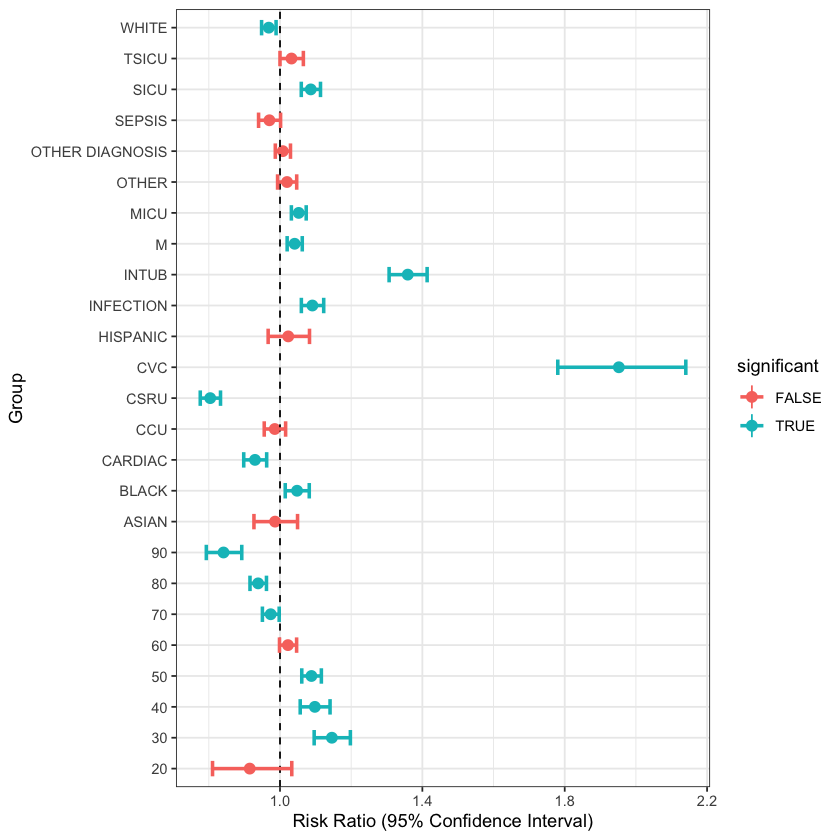

In [387]:
p = ggplot(data=all_rr_df,
    aes(x = ID,y = estimate, ymin = lower, ymax = upper ))+
    geom_pointrange(aes(col=significant))+
    geom_hline(yintercept =1, linetype=2)+
    xlab('Group')+ ylab("Risk Ratio (95% Confidence Interval)")+
    geom_errorbar(aes(ymin=lower, ymax=upper,col=significant),width=0.5,cex=1)+ 
    theme_bw() +
    coord_flip()
plot(p)

# Possible predictors for >24 hrs of pressor usage
- Age, sex, ethnicity
    - to handle age, need to subtract icustarttime from dob as years. Then group round to nearest 10. 
- Diagnosis code (nonvitals_predictor_df)
- Vital signs at 2,4,6,12 hrs before pressor initiation (or a log reg of this) (vitals_df)

In [339]:
all_rr_list <- list()

### Gender effect, greater risk for Male (chi-square, relative risk)

In [352]:
gender_df <- output_df %>%
    group_by(MORETHAN24HOURS, gender) %>%
    summarize(COUNT = n())

#### Chi-Square (Significant) "there is an interaction between sex and response"

In [353]:
gender_df %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("gender") %>%
        as.matrix() %>% chisq.test() 


	Pearson's Chi-squared test with Yates' continuity correction

data:  .
X-squared = 15.118, df = 1, p-value = 0.000101


#### Relative risk (Significant) "there is a different RR for male compared to female for the response"

In [354]:
output <- gender_df %>%
    spread(MORETHAN24HOURS, COUNT) %>%
    tibble::column_to_rownames("gender") %>%
    as.matrix() %>% riskratio()

output

,FALSE,TRUE,Total
F,2161,4705,6866
M,2789,6943,9732
Total,4950,11648,16598
,estimate,lower,upper
F,1.000000,NA,NA
M,1.041092,1.020085,1.062532
,midp.exact,fisher.exact,chi.square
F,NA,NA,NA
M,9.631229e-05,9.888139e-05,9.405792e-05


In [355]:
all_rr_list[['MALE_RR']] <- output$measure %>%
        data.frame() %>%
        tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'M') %>%
        mutate(ID = "M", p = output$p.value["M","fisher.exact"])

### Race, greater risk for Black (chi-square, relative risk)
- ASIAN (grepl ASIAN), BLACK (grepl BLACK), HISPANIC (grepl HISPANIC), WHITE (grepl WHITE)

In [356]:
race_df <- output_df %>%
    rowwise() %>%
    mutate(RACE = simplifyRace(ethnicity)) %>%
    group_by(MORETHAN24HOURS, RACE) %>%
    summarize(COUNT = n())

Warning message:
“Grouping rowwise data frame strips rowwise nature”

#### Chi-Square (Significant) "there is an interaction between race and response"

In [357]:
race_df %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("RACE") %>%
        as.matrix() %>% chisq.test() 


	Pearson's Chi-squared test

data:  .
X-squared = 11.889, df = 4, p-value = 0.0182


#### Relative risk (Some significant) "there is a different RR for X race compared to not X races for the response"

In [358]:
rr_list <- list()
for(race in races){
   output <- race_df %>%
        mutate(RACE_BOOL = RACE == race) %>%
        group_by(RACE_BOOL, MORETHAN24HOURS) %>%
        summarize(COUNT = sum(COUNT)) %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("RACE_BOOL") %>%
        as.matrix() %>% riskratio() 
    rr_list[[race]] <- output$measure %>%
        data.frame() %>%
        tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
        mutate(ID = race, p = output$p.value["TRUE","fisher.exact"])
    cat("\n\n####", race, "####\n\n")
    print(output)
}




#### ASIAN ####

$data
      FALSE  TRUE Total
FALSE  4810 11333 16143
TRUE    140   315   455
Total  4950 11648 16598

$measure
                        NA
risk ratio with 95% C.I.  estimate     lower    upper
                   FALSE 1.0000000        NA       NA
                   TRUE  0.9861399 0.9267862 1.049295

$p.value
         NA
two-sided midp.exact fisher.exact chi.square
    FALSE         NA           NA         NA
    TRUE   0.6512484    0.6776775  0.6545643

$correction
[1] FALSE

attr(,"method")
[1] "Unconditional MLE & normal approximation (Wald) CI"


#### BLACK ####

$data
      FALSE  TRUE Total
FALSE  4544 10538 15082
TRUE    406  1110  1516
Total  4950 11648 16598

$measure
                        NA
risk ratio with 95% C.I. estimate    lower  upper
                   FALSE 1.000000       NA     NA
                   TRUE  1.047911 1.014709 1.0822

$p.value
         NA
two-sided  midp.exact fisher.exact  chi.square
    FALSE          NA           NA          NA
  

In [359]:
all_rr_list[['RACE_RR']] <- bind_rows(rr_list)

### Age effect strong for 30s (wilcox, chi-square, RR greater than, RR within group)

In [361]:
age_df <- output_df %>%
    group_by(MORETHAN24HOURS, age_cohort) %>%
    summarize(COUNT = n()) %>%
    drop_na(age_cohort)

#### Wilcox (Significant) "there is an interaction between age and response"

In [362]:
wilcox.test(as.numeric(output_df$age), as.numeric(output_df$MORETHAN24HOURS))


	Wilcoxon rank sum test with continuity correction

data:  as.numeric(output_df$age) and as.numeric(output_df$MORETHAN24HOURS)
W = 263808612, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


#### Chi-square (Significant) "there is an interaction between age cohort and response"

In [363]:
age_df %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("age_cohort") %>%
        as.matrix() %>% chisq.test() 


	Pearson's Chi-squared test

data:  .
X-squared = 143.81, df = 7, p-value < 2.2e-16


#### Relative risk (Some significant) "there is a different RR for X age cohort compared to not X age cohort for the response"
- People in their 30s tend to end up on pressors >24 hrs (not 20s, or >40+)

In [364]:
rr_list <- list()
for(ac in unique(age_df$age_cohort)){
   output <- age_df %>%
        mutate(AGE_BOOL = age_cohort == ac) %>%
        group_by(AGE_BOOL, MORETHAN24HOURS) %>%
        summarize(COUNT = sum(COUNT)) %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("AGE_BOOL") %>%
        as.matrix() %>% riskratio() 
    rr_list[[ac]] <- output$measure %>%
        data.frame() %>%
        tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
        mutate(ID = as.character(ac), p = output$p.value["TRUE","fisher.exact"])
    cat("\n\n####", ac, "####\n\n")
    print(output)
}



#### 20 ####

$data
      FALSE  TRUE Total
FALSE  4633 11117 15750
TRUE     51    93   144
Total  4684 11210 15894

$measure
                        NA
risk ratio with 95% C.I.  estimate     lower    upper
                   FALSE 1.0000000        NA       NA
                   TRUE  0.9149838 0.8104062 1.033056

$p.value
         NA
two-sided midp.exact fisher.exact chi.square
    FALSE         NA           NA         NA
    TRUE   0.1210691    0.1190291  0.1158809

$correction
[1] FALSE

attr(,"method")
[1] "Unconditional MLE & normal approximation (Wald) CI"


#### 30 ####

$data
      FALSE  TRUE Total
FALSE  4586 10807 15393
TRUE     98   403   501
Total  4684 11210 15894

$measure
                        NA
risk ratio with 95% C.I. estimate    lower    upper
                   FALSE 1.000000       NA       NA
                   TRUE  1.145738 1.095991 1.197743

$p.value
         NA
two-sided   midp.exact fisher.exact  chi.square
    FALSE           NA           NA          NA


In [365]:
all_rr_list[['AGE_RR']] <- bind_rows(rr_list)

#### Relative risk (Some significant) "there is a different RR for X > age cohort compared to X < age cohort for the response"
- People in their 20-40s tend to end up on pressors >24 hrs (not <20s, or >40s)

In [367]:
for(ac in unique(age_df$age_cohort)){
   output <- age_df %>%
        mutate(AGE_BOOL = age_cohort > ac) %>%
        group_by(AGE_BOOL, MORETHAN24HOURS) %>%
        summarize(COUNT = sum(COUNT)) %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("AGE_BOOL") %>%
        as.matrix() %>% riskratio() 
    cat("\n\n####", 'greater than', ac, "####\n\n")
    print(output)
}



#### greater than 20 ####

$data
      FALSE  TRUE Total
FALSE    51    93   144
TRUE   4633 11117 15750
Total  4684 11210 15894

$measure
                        NA
risk ratio with 95% C.I. estimate     lower    upper
                   FALSE 1.000000        NA       NA
                   TRUE  1.092916 0.9680013 1.233949

$p.value
         NA
two-sided midp.exact fisher.exact chi.square
    FALSE         NA           NA         NA
    TRUE   0.1210691    0.1190291  0.1158809

$correction
[1] FALSE

attr(,"method")
[1] "Unconditional MLE & normal approximation (Wald) CI"


#### greater than 30 ####

$data
      FALSE  TRUE Total
FALSE   149   496   645
TRUE   4535 10714 15249
Total  4684 11210 15894

$measure
                        NA
risk ratio with 95% C.I.  estimate   lower     upper
                   FALSE 1.0000000      NA        NA
                   TRUE  0.9136678 0.87474 0.9543279

$p.value
         NA
two-sided   midp.exact fisher.exact   chi.square
    FALSE           N

ERROR: Error in nrow(x): object 'x' not found


### Infectious diagnosis are associated with longer pressor times (chi-square, relative risk)

In [368]:
output_df %>%
    group_by(diagnosis) %>%
    summarize(COUNT = n()) %>%
    arrange(-COUNT) 

diagnosis,COUNT
<fct>,<int>
SEPSIS,1247
PNEUMONIA,849
CONGESTIVE HEART FAILURE,443
HYPOTENSION,327
PANCREATITIS,314
SUBARACHNOID HEMORRHAGE,308
FEVER,288
ABDOMINAL PAIN,279
CORONARY ARTERY DISEASE,245


In [369]:
diagnosis_df <- output_df %>%
    rowwise() %>%
    mutate(simple_diagnosis = simplifyDiagnosis(diagnosis)) %>%
    group_by(simple_diagnosis, MORETHAN24HOURS) %>%
    summarize(COUNT = n()) 

Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [370]:
diagnosis_df 

simple_diagnosis,MORETHAN24HOURS,COUNT
<chr>,<lgl>,<int>
CARDIAC,FALSE,626
CARDIAC,TRUE,1202
INFECTION,FALSE,413
INFECTION,TRUE,1297
OTHER DIAGNOSIS,FALSE,3288
OTHER DIAGNOSIS,TRUE,7805
SEPSIS,FALSE,623
SEPSIS,TRUE,1344


#### Chi-Square (Significant) "there is an interaction between infection diagnosis and response"

In [371]:
diagnosis_df %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("simple_diagnosis") %>%
        as.matrix() %>% chisq.test() 


	Pearson's Chi-squared test

data:  .
X-squared = 46.748, df = 3, p-value = 3.932e-10


#### Relative risk (Significant) "there is a different RR for infection compared to non-infection for the response"

In [372]:
rr_list <- list()
for(s_d in unique(diagnosis_df$simple_diagnosis)){
   output <- diagnosis_df %>%
        mutate(DX_BOOL = simple_diagnosis == s_d) %>%
        group_by(DX_BOOL, MORETHAN24HOURS) %>%
        summarize(COUNT = sum(COUNT)) %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("DX_BOOL") %>%
        as.matrix() %>% riskratio() 
    rr_list[[s_d]] <- output$measure %>%
        data.frame() %>%
        tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
        mutate(ID = s_d, p = output$p.value["TRUE","fisher.exact"])
    cat("\n\n####", s_d, "####\n\n")
    print(output)
}



#### CARDIAC ####

$data
      FALSE  TRUE Total
FALSE  4324 10446 14770
TRUE    626  1202  1828
Total  4950 11648 16598

$measure
                        NA
risk ratio with 95% C.I.  estimate     lower     upper
                   FALSE 1.0000000        NA        NA
                   TRUE  0.9297341 0.8980515 0.9625344

$p.value
         NA
two-sided   midp.exact fisher.exact   chi.square
    FALSE           NA           NA           NA
    TRUE  1.474328e-05 1.439379e-05 1.180322e-05

$correction
[1] FALSE

attr(,"method")
[1] "Unconditional MLE & normal approximation (Wald) CI"


#### INFECTION ####

$data
      FALSE  TRUE Total
FALSE  4537 10351 14888
TRUE    413  1297  1710
Total  4950 11648 16598

$measure
                        NA
risk ratio with 95% C.I. estimate   lower    upper
                   FALSE 1.000000      NA       NA
                   TRUE  1.090933 1.05998 1.122789

$p.value
         NA
two-sided   midp.exact fisher.exact  chi.square
    FALSE           NA  

In [373]:
all_rr_list[['DIAGNOSIS_RR']] <- bind_rows(rr_list)

### Care unit (MICU and SICU end up >24 hrs pressors, not TSICU, CCU, CSRU)

In [374]:
careunit_df <- output_df %>%
    group_by(MORETHAN24HOURS, first_careunit) %>%
    summarize(COUNT = n())

In [375]:
rr_list <- list()
for(cu in unique(careunit_df$first_careunit)){
   output <- careunit_df%>%
        mutate(CU_BOOL = first_careunit == cu) %>%
        group_by(CU_BOOL, MORETHAN24HOURS) %>%
        summarize(COUNT = sum(COUNT)) %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("CU_BOOL") %>%
        as.matrix() %>% riskratio() 
    rr_list[[cu]] <- output$measure %>%
        data.frame() %>%
        tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
        mutate(ID = cu, p = output$p.value["TRUE","fisher.exact"])
    cat("\n\n####", cu, "####\n\n")
    print(output)
}



#### CCU ####

$data
      FALSE  TRUE Total
FALSE  4309 10203 14512
TRUE    641  1445  2086
Total  4950 11648 16598

$measure
                        NA
risk ratio with 95% C.I.  estimate     lower    upper
                   FALSE 1.0000000        NA       NA
                   TRUE  0.9852647 0.9556921 1.015752

$p.value
         NA
two-sided midp.exact fisher.exact chi.square
    FALSE         NA           NA         NA
    TRUE   0.3335555     0.343678  0.3334847

$correction
[1] FALSE

attr(,"method")
[1] "Unconditional MLE & normal approximation (Wald) CI"


#### CSRU ####

$data
      FALSE  TRUE Total
FALSE  3937 10245 14182
TRUE   1013  1403  2416
Total  4950 11648 16598

$measure
                        NA
risk ratio with 95% C.I.  estimate    lower     upper
                   FALSE 1.0000000       NA        NA
                   TRUE  0.8038708 0.775923 0.8328252

$p.value
         NA
two-sided midp.exact fisher.exact chi.square
    FALSE         NA           NA         

In [376]:
all_rr_list[['CAREUNIT_RR']] <- bind_rows(rr_list)

### Intubation effect

In [343]:
intub_df <- output_df %>%
    group_by(MORETHAN24HOURS, intub) %>%
    summarize(COUNT = n())

#### Chi-Square (Significant) "there is an interaction between sex and response"

In [344]:
intub_df %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("intub") %>%
        as.matrix() %>% chisq.test() 


	Pearson's Chi-squared test with Yates' continuity correction

data:  .
X-squared = 349.78, df = 1, p-value < 2.2e-16


#### Relative risk (Significant) "there is a different RR for male compared to female for the response"

In [345]:
output <- intub_df %>%
    spread(MORETHAN24HOURS, COUNT) %>%
    tibble::column_to_rownames("intub") %>%
    as.matrix() %>% riskratio()

output

,FALSE,TRUE,Total
FALSE,1068,1234,2302
TRUE,3882,10414,14296
Total,4950,11648,16598
,estimate,lower,upper
FALSE,1.000000,NA,NA
TRUE,1.358918,1.306549,1.413386
,midp.exact,fisher.exact,chi.square
FALSE,NA,NA,NA
TRUE,0,2.118292e-73,2.991808e-78


In [346]:
all_rr_list[['INTUB_RR']] <- output$measure %>%
        data.frame() %>%
        tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
        mutate(ID = "INTUB", p = output$p.value["TRUE","fisher.exact"])

### CVC effect

In [347]:
intub_df <- output_df %>%
    group_by(MORETHAN24HOURS, cvc) %>%
    summarize(COUNT = n())

#### Chi-Square (Significant) "there is an interaction between sex and response"

In [348]:
intub_df %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("cvc") %>%
        as.matrix() %>% chisq.test() 


	Pearson's Chi-squared test with Yates' continuity correction

data:  .
X-squared = 438.63, df = 1, p-value < 2.2e-16


#### Relative risk (Significant) "there is a different RR for male compared to female for the response"

In [349]:
output <- intub_df %>%
    spread(MORETHAN24HOURS, COUNT) %>%
    tibble::column_to_rownames("cvc") %>%
    as.matrix() %>% riskratio()

output

,FALSE,TRUE,Total
FALSE,498,290,788
TRUE,4452,11358,15810
Total,4950,11648,16598
,estimate,lower,upper
FALSE,1.000000,NA,NA
TRUE,1.952083,1.780479,2.140226
,midp.exact,fisher.exact,chi.square
FALSE,NA,NA,NA
TRUE,0,1.147471e-87,9.307227e-98


In [350]:
all_rr_list[['CVC_RR']] <- output$measure %>%
        data.frame() %>%
        tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
        mutate(ID = "CVC", p = output$p.value["TRUE","fisher.exact"])

# VITALS

### BP (!), HR, RR, TEMPC before pressors significantly differ for >24 hr pressors and interact with time interval. SPO2 and Glucose NS. Only assessed for mean and median. 

### (merge with vitals and compute mean/median values)

In [389]:
vitals_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/vitals.csv')

In [390]:
# takes 6 mins to run (because of difftime)

vitals_merged_df <- vitals_df %>%
    mutate(charttime = fastPOSIXct(charttime)) %>%
    filter(icustay_id %in% output_df$icustay_id) %>%
    left_join(select(output_df, icustay_id, starttime, endtime, MORETHAN24HOURS), by = "icustay_id") %>%
    rowwise() %>%
    mutate(diff = difftime(charttime, 
                       starttime, units="hours"))

Adding missing grouping variables: `course_id`


In [391]:
intervals <- 1:10

In [392]:
results_list <- list()

In [394]:
for(interval in intervals){
    # 2 mins to run
    results_list[[interval]] <- vitals_merged_df %>%
        filter(diff < 0) %>%
        filter(diff < -(interval - 1) & diff > -interval) %>%
        group_by(MORETHAN24HOURS, icustay_id) %>%
        summarize(mean_heartrate = mean(heartrate, na.rm=T), 
                  mean_sysbp = mean(sysbp, na.rm=T),
                  mean_diasbp = mean(diasbp, na.rm=T),
                  mean_meanbp = mean(meanbp, na.rm=T), 
                  mean_resprate = mean(resprate, na.rm=T), 
                  mean_tempc = mean(tempc, na.rm=T), 
                  mean_spo2 = mean(spo2, na.rm=T), 
                  mean_glucose = mean(glucose, na.rm=T), 

                  median_heartrate = median(heartrate, na.rm=T), 
                  median_sysbp = median(sysbp, na.rm=T),
                  median_diasbp = median(diasbp, na.rm=T),
                  median_meanbp = median(meanbp, na.rm=T), 
                  median_resprate = median(resprate, na.rm=T), 
                  median_tempc = median(tempc, na.rm=T), 
                  median_spo2 = median(spo2, na.rm=T), 
                  median_glucose = median(glucose, na.rm=T),

#                   max_heartrate = max(heartrate, na.rm=T), 
#                   max_sysbp = max(sysbp, na.rm=T),
#                   max_diasbp = max(diasbp, na.rm=T),
#                   max_meanbp = max(meanbp, na.rm=T), 
#                   max_resprate = max(resprate, na.rm=T), 
#                   max_tempc = max(tempc, na.rm=T), 
#                   max_spo2 = max(spo2, na.rm=T), 
#                   max_glucose = max(glucose, na.rm=T), 

#                   min_heartrate = min(heartrate, na.rm=T), 
#                   min_sysbp = min(sysbp, na.rm=T),
#                   min_diasbp = min(diasbp, na.rm=T),
#                   min_meanbp = min(meanbp, na.rm=T), 
#                   min_resprate = min(resprate, na.rm=T), 
#                   min_tempc = min(tempc, na.rm=T), 
#                   min_spo2 = min(spo2, na.rm=T), 
#                   min_glucose = min(glucose, na.rm=T)

                 ) %>%
        mutate(INTERVAL = interval)

}

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [397]:
results_df <- bind_rows(results_list)

In [398]:
melt_results_df <- results_df %>% 
    gather("ID", "VALUE", -MORETHAN24HOURS, -icustay_id, -INTERVAL)

#### Continuous (repeated-measures) ANCOVA analysis (that is, without summarizing mean/median vital signs)
- MORETHAN24HOURS P-value tells you if this vital sign is a predictor (BP, HR, RR, TEMP)
- diff P-value tells you if these values change depending on the time point being measured (most values)
- MORETHAN24HOURS:diff P-value tells you if vital sign interacts with the time point being measured, that is, the extent of predictive value. 

Comment:
- This is repeated measures ANCOVA so it also accounts for the pairing from icustay_id
- sysbp, diasbp are not significant by this analysis, but all other measures including glucose and spo2 are signiciant 

In [750]:
# takes 4 mins
filtered_vitals_merged_df <- vitals_merged_df %>% filter(diff < 0)

In [781]:
filtered_vitals_merged_df <- filtered_vitals_merged_df %>%
    mutate(num_diff = as.numeric(diff))

In [782]:
vital_signs <- c('heartrate','sysbp','diasbp','meanbp','resprate','tempc','spo2','glucose')

In [783]:
for(vital in vital_signs){
    cat("####", vital, "####")
    totest <- filtered_vitals_merged_df %>%
        rename(VALUE = !!rlang::sym(vital)) %>%
        select(VALUE, num_diff, MORETHAN24HOURS, icustay_id) %>%
        drop_na(VALUE)

    aov(VALUE ~ MORETHAN24HOURS*num_diff + Error(icustay_id/MORETHAN24HOURS+num_diff), data = totest) %>% summary() %>% print()
}

#### heartrate ####
Error: icustay_id
                Df   Sum Sq  Mean Sq
MORETHAN24HOURS  1 18943018 18943018

Error: num_diff
                Df  Sum Sq Mean Sq
MORETHAN24HOURS  1 1126972 1126972

Error: icustay_id:MORETHAN24HOURS
                Df Sum Sq Mean Sq
MORETHAN24HOURS  1 780627  780627

Error: Within
                             Df    Sum Sq Mean Sq F value Pr(>F)    
MORETHAN24HOURS               1   2531207 2531207    6905 <2e-16 ***
MORETHAN24HOURS:num_diff      1    804018  804018    2193 <2e-16 ***
Residuals                998226 365942387     367                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
#### sysbp ####
Error: icustay_id
                Df Sum Sq Mean Sq
MORETHAN24HOURS  1  15281   15281

Error: num_diff
                Df   Sum Sq  Mean Sq
MORETHAN24HOURS  1 12513508 12513508

Error: icustay_id:MORETHAN24HOURS
                Df  Sum Sq Mean Sq
MORETHAN24HOURS  1 1305246 1305246

Error: Within
                           

In [784]:
head(totest)

VALUE,num_diff,MORETHAN24HOURS,icustay_id
<dbl>,<dbl>,<lgl>,<dbl>
50,-0.5000000,FALSE,200024
425,-0.1166667,FALSE,200029
363,-1.7500000,FALSE,200030
391,-1.2500000,FALSE,200030
121,-19.6333333,TRUE,200059
121,-19.6333333,TRUE,200059


#### ANCOVA analysis using intervals
- MORETHAN24HOURS P-value tells you if this vital sign is a predictor (BP, HR, RR, TEMP)
- INTERVAL P-value tells you if these values change depending on the interval being measured (most values)
- MORETHAN24HOURS:INTERVAL P-value tells you if vital sign interacts with the interval being measured, that is, the extent of predictive value differs with time (BP especially, others are borderline significant)

In [730]:
head(totest)

MORETHAN24HOURS,icustay_id,INTERVAL,ID,VALUE
<lgl>,<dbl>,<int>,<chr>,<dbl>
FALSE,200024,1,max_heartrate,123
FALSE,200028,1,max_heartrate,76
FALSE,200029,1,max_heartrate,-Inf
FALSE,200030,1,max_heartrate,85
FALSE,200065,1,max_heartrate,122
FALSE,200075,1,max_heartrate,86


In [776]:
for(vital in unique(melt_results_df$ID)){
    cat("####", vital, "####")
    totest <- melt_results_df %>%
         filter(ID == vital)
    aov(VALUE ~ MORETHAN24HOURS*INTERVAL, data = totest) %>% summary() %>% print()
}

#### mean_heartrate ####                            Df   Sum Sq Mean Sq F value   Pr(>F)    
MORETHAN24HOURS              1    24979   24979  56.150 6.94e-14 ***
INTERVAL                     1    11744   11744  26.399 2.80e-07 ***
MORETHAN24HOURS:INTERVAL     1     1802    1802   4.051   0.0442 *  
Residuals                25262 11238029     445                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
6261 observations deleted due to missingness
#### mean_sysbp ####                            Df   Sum Sq Mean Sq F value   Pr(>F)    
MORETHAN24HOURS              1    72353   72353  153.99  < 2e-16 ***
INTERVAL                     1   268122  268122  570.65  < 2e-16 ***
MORETHAN24HOURS:INTERVAL     1     6777    6777   14.43 0.000146 ***
Residuals                24954 11724621     470                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
6569 observations deleted due to missingness
#### mean_diasbp ####                     

ERROR: Error in lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...): NA/NaN/Inf in 'y'


In [607]:
melt_results_df %>%
    group_by(MORETHAN24HOURS, ID, INTERVAL) %>%
    summarize(MEAN = mean(VALUE, na.rm = T), SD = sd(VALUE, na.rm = T)) %>%
    rename(HOURSBEFOREPRESSORS = INTERVAL) %>%
    filter(grepl("mean_heartrate", ID))

MORETHAN24HOURS,ID,HOURSBEFOREPRESSORS,MEAN,SD
<lgl>,<chr>,<int>,<dbl>,<dbl>
FALSE,mean_heartrate,1,91.41500,21.21292
FALSE,mean_heartrate,2,92.21219,21.51887
FALSE,mean_heartrate,3,92.65327,21.08484
FALSE,mean_heartrate,4,93.21743,21.09499
FALSE,mean_heartrate,5,92.31238,21.01638
FALSE,mean_heartrate,6,92.16242,20.68711
FALSE,mean_heartrate,7,91.11147,20.10573
FALSE,mean_heartrate,8,90.84620,20.14667
FALSE,mean_heartrate,9,90.64875,19.89788


In [608]:
melt_results_df %>%
    group_by(MORETHAN24HOURS, ID, INTERVAL) %>%
    summarize(MEAN = mean(VALUE, na.rm = T), SD = sd(VALUE, na.rm = T)) %>%
    rename(HOURSBEFOREPRESSORS = INTERVAL) %>%
    filter(grepl("mean_meanbp", ID))

MORETHAN24HOURS,ID,HOURSBEFOREPRESSORS,MEAN,SD
<lgl>,<chr>,<int>,<dbl>,<dbl>
FALSE,mean_meanbp,1,69.35602,15.60029
FALSE,mean_meanbp,2,68.24777,15.87528
FALSE,mean_meanbp,3,70.48433,15.84340
FALSE,mean_meanbp,4,71.64385,16.91313
FALSE,mean_meanbp,5,72.73630,17.26846
FALSE,mean_meanbp,6,72.56045,15.88373
FALSE,mean_meanbp,7,74.25833,16.76144
FALSE,mean_meanbp,8,74.11508,16.69597
FALSE,mean_meanbp,9,74.70031,16.82940


### Table significance (UNPAIRED!!!)

In [436]:
computeTest <- function(d, value="VALUE", comparison="GROUP"){
    paired_df <- d %>% 
        select(!!rlang::sym(comparison), !!rlang::sym(value)) 
    
    items <- unique(unlist(d[,comparison]))

    result_unpair <- t.test(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, 
       filter(d, !!rlang::sym(comparison) == items[2])$VALUE, paired = FALSE)
    result_wilcox <- wilcox.test(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, 
       filter(d, !!rlang::sym(comparison) == items[2])$VALUE, paired = FALSE)
    
    diff = mean(filter(d, !!rlang::sym(comparison) == items[1])$VALUE) -  
        mean(filter(d, !!rlang::sym(comparison) == items[2])$VALUE)
    
    return(data.frame(list(
                           'P_UNPAIR' = result_unpair$p.value, 
                           'P_WILCOX' = result_wilcox$p.value,
                            'GROUP1' = mean(filter(d, !!rlang::sym(comparison) == items[1])$VALUE),
                            'GROUP2' = mean(filter(d, !!rlang::sym(comparison) == items[2])$VALUE),
                            'DIFF' = diff,
                            'COMPARE' = paste(items[1], items[2], sep ='-'))))
}

In [437]:
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    group_by(ID) %>%
    do(computeTest(.,value="VALUE", comparison="MORETHAN24HOURS")) %>%
    mutate(significant = P_WILCOX < 0.05)

ID,P_UNPAIR,P_WILCOX,GROUP1,GROUP2,DIFF,COMPARE,significant
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
mean_diasbp,1.265908e-01,7.990480e-02,54.65006,54.01456,0.6354959,FALSE-TRUE,FALSE
mean_glucose,1.453990e-01,1.298682e-01,164.73997,159.43578,5.3041867,FALSE-TRUE,FALSE
mean_heartrate,7.396542e-09,6.240572e-10,91.07418,94.58918,-3.5150026,FALSE-TRUE,TRUE
mean_meanbp,3.468222e-02,1.985997e-03,69.63378,68.66941,0.9643703,FALSE-TRUE,TRUE
mean_resprate,6.778389e-11,1.444753e-10,19.26933,20.39776,-1.1284338,FALSE-TRUE,TRUE
mean_spo2,2.552621e-01,3.172923e-05,96.50264,96.29761,0.2050311,FALSE-TRUE,TRUE
mean_sysbp,5.848989e-05,1.667281e-07,103.46338,101.02786,2.4355228,FALSE-TRUE,TRUE
mean_tempc,9.100300e-03,5.935066e-03,36.57469,36.71611,-0.1414213,FALSE-TRUE,TRUE
median_diasbp,1.570693e-01,1.164519e-01,54.43520,53.83966,0.5955390,FALSE-TRUE,FALSE


### ANCOVA Plotting

In [461]:
toplot <- melt_results_df %>%
    mutate(INTERVAL = -INTERVAL) %>%
    drop_na(VALUE) %>%
    filter(grepl("mean_", ID))

In [462]:
options(repr.plot.width=10, repr.plot.height=3)
g <- ggplot(toplot, 
            aes(x=toplot$INTERVAL, y=toplot$VALUE, color=factor(toplot$MORETHAN24HOURS))) +
#geom_point() + 
geom_smooth(method=lm, aes(fill=factor(toplot$MORETHAN24HOURS))) + 
xlab("Hours before pressors") + ylab("Value") +
theme_classic() + theme(legend.title = element_blank()) +
facet_wrap(. ~ ID, scale="free", nrow=1)

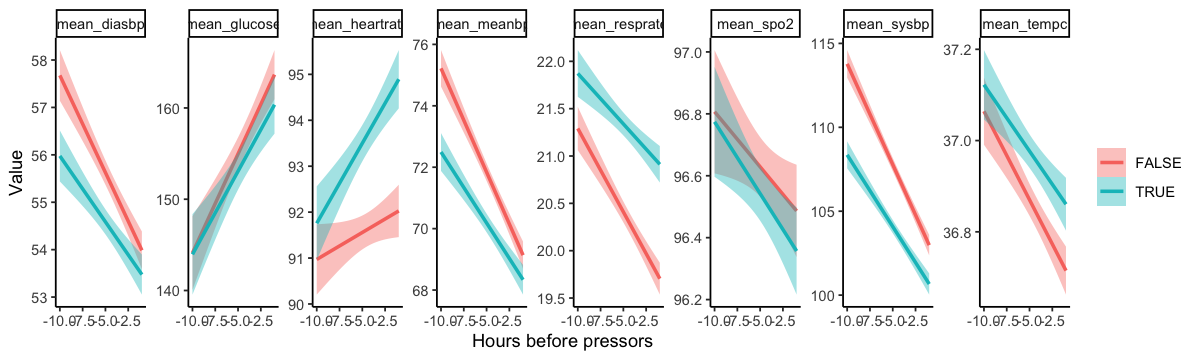

In [463]:
plot(g)

# Model ideas:
- Age, Sex, Race + Continuous Vitals + Class of Diagnosis

# OLD PLOTTING CODE

In [216]:
diff_melt_results_df <- melt_results_df %>%
    mutate(LESS4H_FAC = if(LESS4H){"ACUTE"}else{"BEFORE"}) %>%
    ungroup() %>%
    select(-LESS4H) %>%
    spread(key=LESS4H_FAC, value=VALUE) %>%
    mutate(DIFF = ACUTE - BEFORE) %>%
    drop_na(DIFF)

In [219]:
diff_melt_results_df %>%
    group_by(ID) %>%
    summarize(MEAN = mean(DIFF), MEDIAN = median(DIFF), SD = sd(DIFF)) %>%
    filter(grepl("mean_", ID))

ID,MEAN,MEDIAN,SD
<chr>,<dbl>,<dbl>,<dbl>
mean_diasbp,-5.0795903,-4.6190476,10.5574709
mean_glucose,-1.0703783,-2.0000000,57.3764423
mean_heartrate,0.5978909,-0.2500000,15.0400201
mean_meanbp,-6.2249491,-5.9400000,12.7268102
mean_resprate,-0.1385922,0.0000000,4.6541797
mean_spo2,-0.4325486,0.0000000,4.7919907
mean_sysbp,-10.4044132,-9.5045455,17.7648518
mean_tempc,0.1458291,0.1249992,0.9608547


In [220]:
diff_melt_results_df %>%
    group_by(ID) %>%
    summarize(MEAN = mean(DIFF), MEDIAN = median(DIFF), SD = sd(DIFF)) %>%
    filter(grepl("median_", ID))

ID,MEAN,MEDIAN,SD
<chr>,<dbl>,<dbl>,<dbl>
median_diasbp,-4.72675829,-4.0000000,10.9233758
median_glucose,1.93764511,0.0000000,58.6315656
median_heartrate,0.94528754,0.0000000,16.0242214
median_meanbp,-5.88472780,-5.2500000,13.2660207
median_resprate,-0.04557188,0.0000000,5.0407835
median_spo2,-0.52318959,0.0000000,4.7320416
median_sysbp,-10.12702102,-9.0000000,19.2407517
median_tempc,0.14083532,0.1111094,0.9843607


### Plotting

In [224]:
# icustay_ids being plotted
melt_results_df %>% select(icustay_id) %>% unlist() %>% unique() %>% length()

Adding missing grouping variables: `LESS4H`


[1] 5127

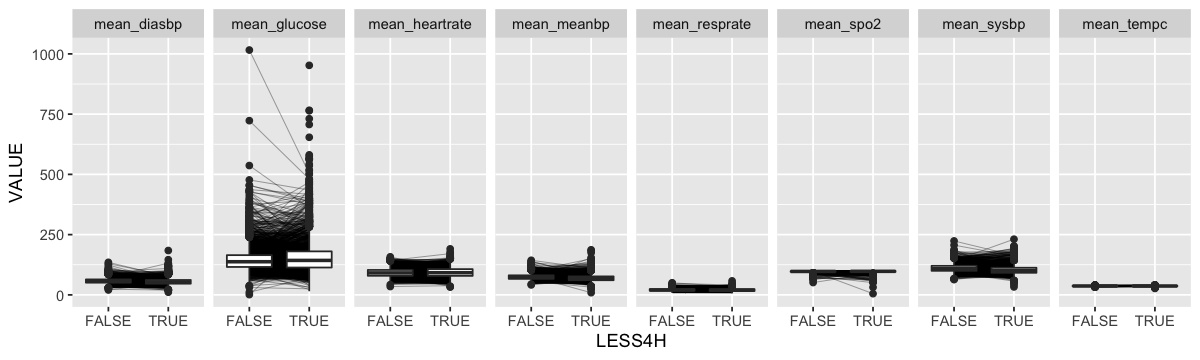

In [177]:
options(repr.plot.width=10, repr.plot.height=3)
melt_results_df %>%
    filter(grepl("mean_", ID)) %>%
    ggplot(aes(x = LESS4H, y = VALUE)) +
    geom_line(aes(group = icustay_id), size = 0.1) +
    geom_boxplot() +
    facet_grid(~ID)

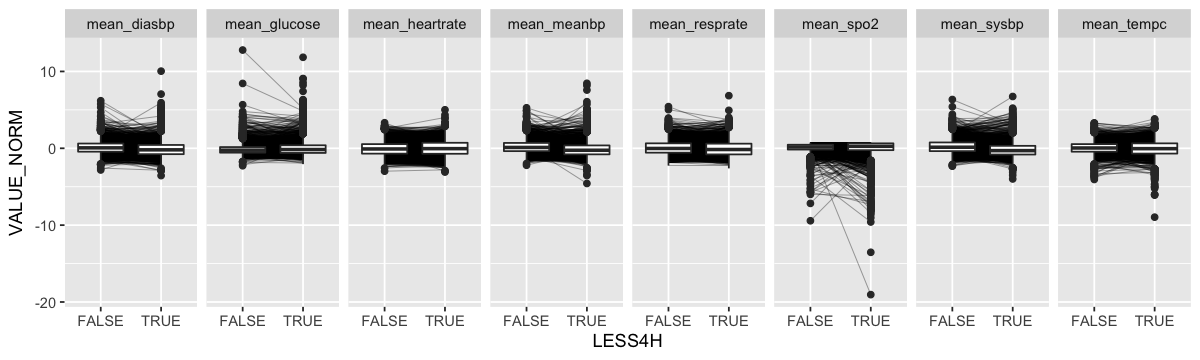

In [184]:
options(repr.plot.width=10, repr.plot.height=3)
melt_results_norm_df %>%
    filter(grepl("mean_", ID)) %>%
    ggplot(aes(x = LESS4H, y = VALUE_NORM)) +
    geom_line(aes(group = icustay_id), size = 0.1) +
    geom_boxplot() +
    facet_grid(~ID)

In [225]:
diff_melt_results_df %>% select(icustay_id) %>% unlist() %>% unique() %>% length()

[1] 2911

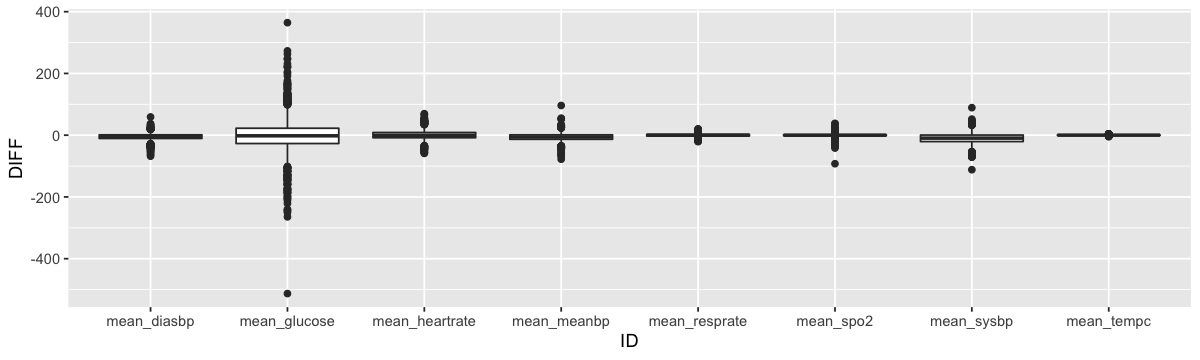

In [218]:
# icustay_ids being plotted
diff_melt_results_df %>%
    filter(grepl("mean_", ID)) %>%
    ggplot(aes(x = ID, y = DIFF)) +
    geom_boxplot()